In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import artm
import codecs
import sys
import scipy
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
from scipy.sparse import csr_matrix
from scipy.stats import spearmanr
from collections import defaultdict

## Similarity evaluation helpers

In [2]:
TESTSETS_FOLDER = './testsets/ws/'

testsets = [("ws353_sim", TESTSETS_FOLDER + 'ws353_similarity.txt'),
            ("ws353_rel", TESTSETS_FOLDER + 'ws353_relatedness.txt'),
            ("ws353", TESTSETS_FOLDER + 'ws353.txt'),
            ("simlex999", TESTSETS_FOLDER + 'simlex_999.txt'),
            ("bruni_men", TESTSETS_FOLDER + 'bruni_men.txt'),
            ("luong_rare", TESTSETS_FOLDER + 'luong_rare.txt'),
            ("mturk", TESTSETS_FOLDER + 'radinsky_mturk.txt')]

In [3]:
TESTSETS_FOLDER = './testsets/ws/russian/'

russian_testsets = [("ws353_sim", TESTSETS_FOLDER + 'hj-wordsim353-similarity.txt'),
            ("ws353_rel", TESTSETS_FOLDER + 'hj-wordsim353-relatedness.txt'),
            ("hj", TESTSETS_FOLDER + 'hj.txt'),
            ("simlex999", TESTSETS_FOLDER + 'simlex-999.txt'),
            ("mj", TESTSETS_FOLDER + 'mj.txt')]

In [4]:
def load_human_ratings(path, words):
    """ 
    Loads word pair similarities provided by humans.
    
    Args:
      path (string): full path to the file with [word word similarity] lines.
      words (dict): vocabulary of words. The similarities are loaded 
        only for words pairs covered by the vocabulary. 
        
    Returns:
      human_ratings (dict): mapping from a tuple of words to their similarity.
      coverage (float): a ratio of word pairs covered by the vocabulary.
    """
    
    human_ratings = {}
    added = 0
    total = 0
    with codecs.open(path, encoding='utf-8') as fin:
        for line in fin:
            (word1, word2, sim) = line.split()
            total += 1
            if word1 in words and word2 in words:
                human_ratings[(word1, word2)] = float(sim)
                added += 1
    return human_ratings, 1.0 * added / total


def cos_sim(vec1, vec2):
    return sklearn.metrics.pairwise.cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

def log_cos_sim(vec1, vec2, alpha=0.0000001):
    vec1 = np.log(vec1 + alpha)
    vec2 = np.log(vec2 + alpha)
    return sklearn.metrics.pairwise.cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

def dot_sim(vec1, vec2):
    return vec1.dot(vec2)

def hel_sim(vec1, vec2):
    # One more sqrt and division by sqrt(2) omitted, minus added.
    return -np.sum((np.sqrt(vec1) - np.sqrt(vec2)) ** 2)


def evaluate_sim_task(human_ratings, embeddings_df, similarity_fn):
    """
    Get Spearman correlation for human and model rankings.
    
    Args:
      human_rating (dict): mapping from word tuples to their similarity.
      embeddings_df (pandas dataframe): each row corresponds to a word vector.
      similatity_fn (vec1, vec2 -> sim): computes similarity of two vectors.
      
    Returns:
      Quality on the word similarity task (Spearman correlation).
    
    """
   
    model_ratings = {key : similarity_fn(
            embeddings_df.loc[key[0]], embeddings_df.loc[key[1]]) for key in human_ratings}
 
    (sorted_keys, sorted_model) = zip(*sorted(model_ratings.items(), key=lambda x: -x[1]))
    
    return scipy.stats.spearmanr(sorted_model, [human_ratings[k] for k in sorted_keys])[0]

In [5]:
def similarity_report(testsets_list, embeddings_list, experiment_name):
    """
    Produces a report for several testsets and for several embedding dataframes.
    
    It is assumed, that the vocabulary is the same for all compared embeddings
    and can be infered e.g. as index of the first dataframe.
    
    Args:
      testsets (dict): name-to-path mapping for word similarity testsets.
      embeddings_list (list): list of (name, dataframe of embeddings) tuples.
      experiment_name (string): a prefix for all rows in the produced report. 
    
    """
    report = []
    columns = []
    vocabulary = embeddings_list[0][1].index
    
    for testset_name, testset_path in testsets_list:
        human_ratings, _ = load_human_ratings(testset_path, vocabulary)
        testset_report = [testset_name]
        columns = [' ']
        
        for name, embeddings in embeddings_list:          
            sim = evaluate_sim_task(human_ratings, embeddings, similarity_fn = dot_sim) 
            full_name = experiment_name + '_' + str(name) + '_' + 'dot'
            testset_report += [sim]
            columns += [full_name]

        report.append(testset_report)
        
    report_df = pd.DataFrame(report, columns=columns)
    return report_df.set_index(' ').transpose()

## Evaluate embeddings from ARTM models

In [16]:
DATA_FOLDER = "./"
VW_PATH = DATA_FOLDER + "vw_counts_win5" # "vw_counts_sym" 
BATCHES_FOLDER = DATA_FOLDER + "batches_win5/"  # "batches_sym/"
MODELS_FOLDER = DATA_FOLDER + "models/"

In [20]:
batch_vectorizer = artm.BatchVectorizer(data_path=BATCHES_FOLDER, data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=BATCHES_FOLDER + 'dictionary.dict')

In [18]:
model_name = "wntm20btm20_t400_win5"
model_path = MODELS_FOLDER + model_name

model = artm.ARTM(num_topics=400, dictionary=dictionary, ptd_name="ptd",
                cache_theta=True, reuse_theta=True, num_document_passes=1,
                theta_columns_naming='title', num_processors=3)
model.load(model_path)

In [21]:
model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
nwt = model.get_phi(model_name = model.model_nwt)
phibayes = nwt.div(nwt.sum(axis=1), axis=0)

In [34]:
report = similarity_report(testsets, [('phibayes', phibayes)], 'wntm20btm20')

ws353_sim
ws353_rel
ws353
simlex999
bruni_men
luong_rare
mturk


In [35]:
report

,ws353_sim,ws353_rel,ws353,simlex999,bruni_men,luong_rare,mturk
wntm20btm20_phibayes_dot,0.710578,0.645008,0.659756,0.264435,0.683269,0.353178,0.585874


## Evaluate embeddings from text format

In [92]:
model_names = ["psd", "sgns.108"]
embeddings_list = []

for name in model_names:
    print name
    
    embeddings_path = "ruwiki.{}.256.text".format(name)
    list_of_vectors = [] 
    list_of_words = []

    with codecs.open(embeddings_path, encoding='utf-8') as fin:
        fin.readline() # skip the heading
        for line in fin:
            list_of_words.append(line.split()[0])
            list_of_vectors.append([float(x) for x in line.split()[1:]])          
            
    df = pd.DataFrame(list_of_vectors)
    df.index = list_of_words
    df.head()
    
    embeddings_list.append((name, df))
    
     
report = similarity_report(russian_testsets, embeddings_list, 'ruwiki')

psd
sgns.108


In [93]:
report

,ws353_sim,ws353_rel,hj,simlex999,mj
ruwiki_psd_cos,0.515433,0.282588,0.424376,0.102496,0.668547
ruwiki_sgns.108_cos,0.643685,0.445040,0.582281,0.196755,0.761017


In [91]:
report

,ws353_sim,ws353_rel,hj,simlex999,mj
ruwiki_psd_cos,0.515433,0.282588,0.424376,0.102496,0.668547
ruwiki_sgns_cos,0.655427,0.475853,0.595983,0.183367,0.761198
ruwiki_cbow_cos,0.574967,0.343933,0.492519,0.160844,0.735038


In [73]:
report = similarity_report(russian_testsets, [('psd', psd_df)], 'wiki100k')

In [74]:
report

,ws353_sim,ws353_rel,hj,simlex999,mj
wiki100k_psd_cos,0.515433,0.282588,0.424376,0.102496,0.668547


## Evaluate embeddings from sparse matrices

In [78]:
import pickle
import json

In [77]:
with open("./thetaless/word_to_number_dict.txt", 'rb') as fin:
    smth = json.load(fin)
    
vocab = sorted(smth.items(), key=lambda x: x[1])
vocab = zip(*vocab)[0]

In [79]:
model_names = ['plsa', 'plsa_honest', 'plsa_origin', 'plsa_semi_honest', 'tARTM', 'tARTM_cheat']

In [80]:
embeddings_list = []

for name in model_names:
    path = "./thetaless/{}/exp_seed_777_topics_100_iters_60.pkl".format(name) 

    with open(path, 'rb') as fin:
        smth = pickle.load(fin)

    nwt = pd.DataFrame(smth['n_tw']).transpose()
    phibayes = nwt.div(nwt.sum(axis=1), axis=0)
    phibayes.index = vocab
    
    embeddings_list.append((name, phibayes))
    

In [84]:
report = similarity_report(testsets, embeddings_list, '16.11')
report

# btm - 1, wntm - 3, tARTM - 5

,ws353_sim,ws353_rel,ws353,simlex999,bruni_men,luong_rare,mturk
16.11_plsa_dot,0.491129,0.287254,0.395709,0.170076,0.436830,0.160368,0.376926
16.11_plsa_honest_dot,-0.004289,0.026125,0.036914,0.058451,0.021842,0.097006,-0.076658
16.11_plsa_origin_dot,0.632485,0.569386,0.579184,0.196975,0.607177,0.329449,0.536203
16.11_plsa_semi_honest_dot,0.476283,0.322395,0.415156,0.189769,0.421581,0.155193,0.351210
16.11_tARTM_dot,0.613224,0.504292,0.528853,0.181160,0.571371,0.279008,0.497393
16.11_tARTM_cheat_dot,0.121584,0.096382,0.098510,0.117648,0.129353,0.125946,0.050076


## Evaluate embeddings from csv


In [91]:
green_phibayes = pd.read_csv("./green_phibayes.csv", index_col=0)

In [92]:
green_phibayes.shape

(99998, 400)

In [93]:
green_phibayes.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_390,topic_391,topic_392,topic_393,topic_394,topic_395,topic_396,topic_397,topic_398,topic_399
aa,2.909020e-04,0,1.841270e-06,1.522560e-08,2.621054e-06,0.000905,0.006175,2.842573e-14,0,0.000006,...,0.000493,2.727059e-11,1.772150e-04,1.966651e-03,1.043606e-04,0.004844,2.866449e-12,0,4.686652e-12,0.000658
aaa,1.969261e-09,0,2.027035e-15,1.080729e-07,6.535863e-15,0.000463,0.003764,0.000000e+00,0,0.000000,...,0.000000,6.311331e-14,3.407772e-13,6.362937e-09,7.465723e-09,0.000002,0.000000e+00,0,3.060971e-10,0.000000
aaaa,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0,0.000000e+00,0.000000
aaaaa,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.588000e-12,0.000000,0.000000e+00,0,0.000000e+00,0.000000
aaaaaa,0.000000e+00,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,1.696615e-14,0,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0,0.000000e+00,0.000000


In [94]:
report = similarity_report(testsets, [('phibayes', green_phibayes)], 'green')

In [95]:
report

,ws353_sim,ws353_rel,ws353,simlex999,bruni_men,luong_rare,mturk
green_phibayes_dot,0.722974,0.674914,0.681693,0.265164,0.672023,0.367684,0.642016


## Sparsity experiment (should not be in this notebook)

In [96]:
def get_sparsity(df):
    return (df == 0).sum().sum() * 1.0 / df.size

In [97]:
get_sparsity(green_phibayes)

0.81911710734214682

In [211]:
# Naively increase the sparsity

sparse = green_phibayes.copy()
sparse[sparse < 0.01] = 0 

In [212]:
report = similarity_report(testsets, [('sparse', sparse)], 'green')
report

,ws353_sim,ws353_rel,ws353,simlex999,bruni_men,luong_rare,mturk
green_sparse_dot,0.730168,0.668927,0.678768,0.262137,0.661448,0.362753,0.628011


In [213]:
get_sparsity(sparse)

0.97798895977919553

In [45]:
(sparse.loc['at'] != 0).sum()

23

In [41]:
(sparse.loc['algebra'] != 0).sum()

4

In [215]:
sparse['nonzeros'] = (sparse != 0).sum(axis=1)

In [ ]:
vocab = []
total = 0

with codecs.open("./counts_win5.words.vocab", 'r') as fin:
    for line in fin:
        s = line.split()
        vocab.append((s[0], float(s[1])))
        total += float(s[1])
        
frequencies = pd.DataFrame(vocab)
frequencies.columns = ['id', 'value']
frequencies['value'] = frequencies.value / frequencies.value.sum()
frequencies.set_index('id', inplace=True)

# Add the frequency column
sparse['freq'] = frequencies.value

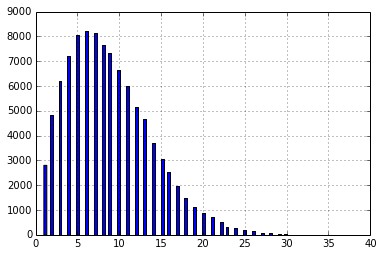

In [216]:
sparse['nonzeros'].hist(bins=100)

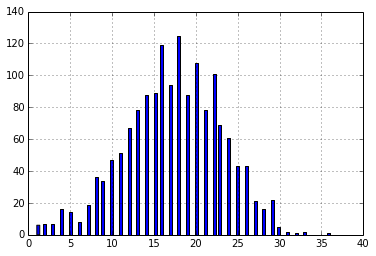

In [238]:
sparse[sparse.freq > 0.0001]['nonzeros'].hist(bins=100)

In [253]:
data = sparse.ix[:, ['nonzeros', 'freq']]

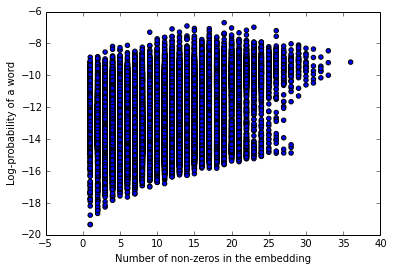

In [297]:
# Plot sparsity for x and log-freqiency for y

plt.scatter(data.nonzeros, np.log(data.freq))
plt.xlabel('Number of non-zeros in the embedding')
plt.ylabel('Log-probability of a word')
plt.show()

In [257]:
sorted_data = data.sort_values(by='nonzeros', ascending=False)

In [266]:
sorted_data[:20]

,nonzeros,freq
direct,36,0.000104
nevertheless,33,0.000046
whole,33,0.000101
named,33,0.000212
hence,32,0.000060
extended,32,0.000081
simultaneously,32,0.000039
person,32,0.000143
producing,32,0.000071
occasionally,32,0.000058


In [301]:
data['logfreq'] = data.freq.apply(np.log)

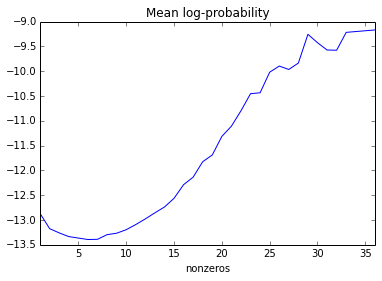

In [304]:
f = data.groupby('nonzeros').logfreq.mean().plot(title='Mean log-probability')

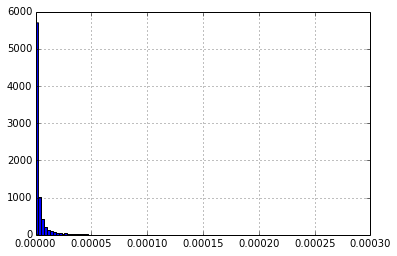

In [307]:
sparse[sparse.nonzeros == 5]['freq'].hist(bins=100)

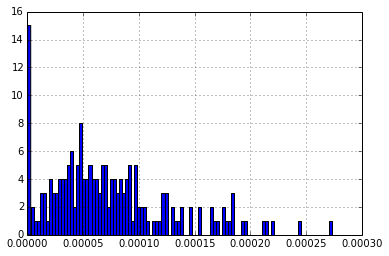

In [308]:
sparse[sparse.nonzeros == 25]['freq'].hist(bins=100)

In [315]:
bank_topics = (sparse.ix['bank', :400])

In [316]:
bank_topics.argmax()

'topic_280'

In [327]:
bank_topics.sort_values(ascending=False)[:5]

topic_280    0.262086
topic_199    0.115313
topic_350    0.062059
topic_89     0.034289
topic_175    0.028594
Name: bank, dtype: float64

In [329]:
sparse['topic_280'].sort_values(ascending=False)[:10] # названия крупных банков

wipro          0.907730
nyse           0.898632
citigroup      0.894214
icici          0.877510
buyouts        0.858424
citibank       0.832623
cognizant      0.825587
financials     0.815430
divestiture    0.807651
hsbc           0.791194
Name: topic_280, dtype: float64

In [330]:
sparse['topic_119'].sort_values(ascending=False)[:10] # почему-то испанский

desde        0.985469
palabra      0.983481
otros        0.979942
cosas        0.979380
porvenir     0.973555
tiempos      0.973312
nuevos       0.965437
distrital    0.964527
mujer        0.962286
mismo        0.961444
Name: topic_119, dtype: float64

In [333]:
sparse['topic_350'].sort_values(ascending=False)[:10] # география и вода

intracoastal    0.999605
nescopeck       0.994311
catawissa       0.980456
mahanoy         0.971782
tunkhannock     0.970600
umpqua          0.940420
waterway        0.919040
tributaries     0.898422
shamokin        0.893938
headwaters      0.857023
Name: topic_350, dtype: float64

In [335]:
sparse['topic_89'].sort_values(ascending=False)[:10]

ecosoc             0.989727
nongovernmental    0.982560
dfid               0.951307
chairing           0.910218
unfpa              0.880272
upu                0.860525
ifad               0.860021
unctad             0.847153
undp               0.845530
ordinating         0.840026
Name: topic_89, dtype: float64

In [336]:
sparse['topic_175'].sort_values(ascending=False)[:10]

lumbering        0.866337
importers        0.857699
commodity        0.792064
commodities      0.748133
cftc             0.693091
mechanisation    0.681049
exporters        0.678140
deregulated      0.677911
smes             0.674914
agribusiness     0.670193
Name: topic_175, dtype: float64